# Tutorial Geomagnetic Field Inversions
This is a tutorial for using the Geomagnetic Field Inversions code written by Frenk Out, Liz van Grinsven, Monika Korte, and Lennart de Groot. This tutorial will guide you through the following process:
1. Loading and Fitting data
2. Starting the model
    1. Initiating a FieldInversion class and add data
    2. Run a time-dependent standard iterative inversion
    3. Plotting results
3. Sweeping through models to find optimal damping parameters (optional)
4. Run an inversion at one time (optional)

### 0. Loading libraries
This tutorial requires, besides geomagnetic_field_inversions, numpy, pandas, pathlib, matplotlib, and cartopy. The geomagnetic_field_inversions code consists of three files:
1. StationData is a class that prepares geomagnetic field data to be inputted in FieldInversion later.
2. FieldInversion is the main class where all calculations happen.
3. plot_tools is a plotting module that helps to create frequently used plots in a easy way.

In [1]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
# Necessary for loading excel or csv files
import pandas as pd
# Necessary for correct path handling
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
# Cartopy is only required for plotting world maps
import cartopy.crs as ccrs

# Our code
from geomagnetic_field_inversions import plot_tools as plot_tools
from geomagnetic_field_inversions import StationData
from geomagnetic_field_inversions import FieldInversion

## 1. Loading and Fitting data
#### Set-up
We will now proceed to loading and fitting the data. This is required to run the inversion later. The basic input for adding and fitting the data is latitude and longitude of each sample location. After the class is initiated, data can be added. This data can be inclination, declination, or intensity data, but also X, Y, Z, or H magnetic data.

In [2]:
# Set a path to load and save files
# path should be like: .../geomagnetic_field_inversions/doc
path = Path().absolute()
# location of our 'mock' dataset
excel = pd.ExcelFile(path / 'first run_reversetime.xlsx')
# the latitude and longitude of out 6 stations in degrees
lat = [0.1, 35.0, 8.0, 35.9, 5.0, 60.7]
lon = [336.7, 140.0, 121.0, 243.0, 73.0, 336.6]

#### *StationData and add_data*
Now that we have set the groundwork, we can proceed to adding and fitting the individual datasets. All data belonging to the same location can be added to the same class. First we initiate a class for the station using its latitude and longitude. After that, we add data belonging to that station separately (from the spreadsheet) and finally fit a line through it.

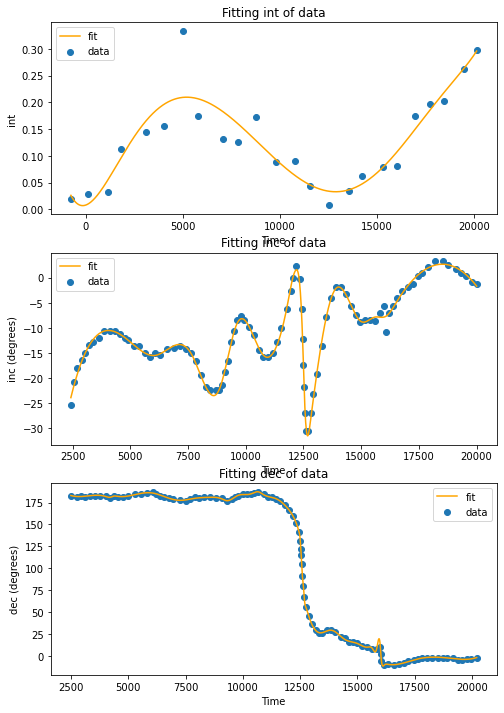

In [3]:
# Start by initializing a new class using latitude and longitude of the station
oda_2000 = StationData(lat[2], lon[2])

# We inputted time as kiloyears, so our timefactor is 1000
oda_2000.add_data('int', (pd.read_excel(excel, 'Oda_2000').iloc[:, [4, 5]].dropna().T.values.tolist()), 1000, error=1)
oda_2000.add_data('inc', (pd.read_excel(excel, 'Oda_2000').iloc[:, [0, 1]].dropna().T.values.tolist()), 1000)
oda_2000.add_data('dec', (pd.read_excel(excel, 'Oda_2000').iloc[:, [2, 3]].dropna().T.values.tolist()), 1000)

# The fitting method fits a line through the data points
# Since we specified output, we we will see the resulting graphs
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
oda_2000.fitting(order=[8, 3, 3], smoothing=[None, 50, 100], method=['polyfit', 'USpline', 'USpline'], ax=axes)
plt.show()

In [4]:
# Now we fit the rest, but do not show the output
# By providing output='YOUR_PATH_NAME' you can observe the plots
valet_1989 = StationData(lat[0], lon[0])
valet_1989.add_data('int', (pd.read_excel(excel, 'Valet_1989').iloc[:, [4, 5]].dropna().T.values.tolist()), 1000, error=1)
valet_1989.add_data('inc', (pd.read_excel(excel, 'Valet_1989').iloc[:, [0, 1]].dropna().T.values.tolist()), 1000)
valet_1989.add_data('dec', (pd.read_excel(excel, 'Valet_1989').iloc[:, [2, 3]].dropna().T.values.tolist()), 1000)
valet_1989.fitting()

haneda_2020 = StationData(lat[1], lon[1])
haneda_2020.add_data('int', (pd.read_excel(excel, 'Haneda_2020').iloc[:, [4, 5]].dropna().T.values.tolist()), 1000, error=1)
haneda_2020.add_data('inc', (pd.read_excel(excel, 'Haneda_2020').iloc[:, [0, 1]].dropna().T.values.tolist()), 1000)
haneda_2020.add_data('dec', (pd.read_excel(excel, 'Haneda_2020').iloc[:, [2, 3]].dropna().T.values.tolist()), 1000)
haneda_2020.fitting()

valet_1988 = StationData(lat[3], lon[3])
valet_1988.add_data('int', (pd.read_excel(excel, 'Valet_1988').iloc[:, [4, 5]].dropna().T.values.tolist()), 1000, error=1)
valet_1988.add_data('inc', (pd.read_excel(excel, 'Valet_1988').iloc[:, [0, 1]].dropna().T.values.tolist()), 1000)
valet_1988.add_data('dec', (pd.read_excel(excel, 'Valet_1988').iloc[:, [2, 3]].dropna().T.values.tolist()), 1000)
valet_1988.fitting(order=[3, 14, 10], smoothing=[0.02, None, None], method=['USpline', 'polyfit', 'polyfit'])

valet_2014 = StationData(lat[4], lon[4])
valet_2014.add_data('int', (pd.read_excel(excel, 'Valet_2014').iloc[:, [4, 5]].dropna().T.values.tolist()), 1000, error=1)
valet_2014.add_data('inc', (pd.read_excel(excel, 'Valet_2014').iloc[:, [0, 1]].dropna().T.values.tolist()), 1000)
valet_2014.add_data('dec', (pd.read_excel(excel, 'Valet_2014').iloc[:, [2, 3]].dropna().T.values.tolist()), 1000)
valet_2014.fitting(order=[8, 8, 5])

channell_2000 = StationData(lat[5], lon[5])
channell_2000.add_data('int', (pd.read_excel(excel, 'Channell_2000').iloc[:, [4, 5]].dropna().T.values.tolist()), 1000, error=1)
channell_2000.add_data('inc', (pd.read_excel(excel, 'Channell_2000').iloc[:, [0, 1]].dropna().T.values.tolist()), 1000)
channell_2000.add_data('dec', (pd.read_excel(excel, 'Channell_2000').iloc[:, [2, 3]].dropna().T.values.tolist()), 1000)
channell_2000.fitting(order=[15, 10, 10])

Our data is now ready to be used in the next step
- Note: the warning for declinations and/or inclinations falling of range can be ignored most of the times

## 2. Starting the model
### 2. Initiate a FieldInversion class and add data
#### *FieldInversion*
The `FieldInversion`-class is the 'location' where we will perform all calculations. We start a FieldInversion class by calling
- `MyInstance = FieldInversion(time_array=np.linspace(3000, 17000, 15), verbose=True)` 

The time_array contains the timesteps over which we want to invert our data; the verbosity flag helps us to understand what is going on in the code.

More parameters can be changed, but we will not do that for now.
&rarr; For more info about other parameters of this class, type:
`FieldInversion?`

In [5]:
# input modeled time array; from 3000 to 17000 with steps of 1000 yr
test_inv = FieldInversion(time_array = np.linspace(0, 20000, 21), verbose=True)

# FieldInversion?

#### *add_data*
After we have initiated the `FieldInversion`-class, we add our data by simply calling the `add_data`-method and adding the fitted classes from the previous step.

In [6]:
test_inv.add_data(valet_1989)
test_inv.add_data(haneda_2020)
test_inv.add_data(oda_2000)
test_inv.add_data(valet_1988)
test_inv.add_data(valet_2014)
test_inv.add_data(channell_2000)

Adding int-type
Adding inc-type
Adding dec-type
Coordinates are geodetic, translating to geocentric coordinates.
Data is added to class
Adding int-type
Adding inc-type
Adding dec-type
Coordinates are geodetic, translating to geocentric coordinates.
Data is added to class
Adding int-type
inc of dataclass not covering start time
Adding inc-type
dec of dataclass not covering start time
Adding dec-type
Coordinates are geodetic, translating to geocentric coordinates.
Data is added to class
Adding int-type
inc of dataclass not covering start time
Adding inc-type
dec of dataclass not covering start time
Adding dec-type
Coordinates are geodetic, translating to geocentric coordinates.
Data is added to class
Adding int-type
inc of dataclass not covering start time
Adding inc-type
Adding dec-type
Coordinates are geodetic, translating to geocentric coordinates.
Data is added to class
Adding int-type
Adding inc-type
Adding dec-type
Coordinates are geodetic, translating to geocentric coordinates.
Da

The output tells us that the different datatypes are successfully added to the `FieldInversion`-class. Additionally, the coordinates of the sample stations are translated into a geocentric reference frame, since they are given in a geodetic reference frame. If you want to know more about this, type `FieldInversion?`

### B. Run a time-dependent standard iterative inversion
After we have set up the class, we can proceed to the geomagnetic field inversion.
#### *prepare_inversion*
First we have to prepare all matrices before execution. For that purpose we need two parameters:
- spatial_df: the spatial damping factor
- temporal_df: the temporal damping factor

For illustrative purposes, we set these damping factors to 3e-10 and 1e-2 respectively. Normally you would have to investigate which combination of damping parameters is best (see section 3).

In [7]:
test_inv.prepare_inversion(spatial_df = 3e-10, temporal_df = 1e-2)

Calculating Schmidt polynomials and Fréchet coefficients
Setting up splines and timeknots
Setting up spatial damping matrix
Setting up temporal damping matrix


#### *run_inversion*
Now we have prepared everything for the inversion. We can now proceed to starting the iterative inversion by using the `run_inversion`-method. This method requires at least a starting model. We will use a starting model with where only $g_1^0$ has a value of -30000.

we also set the maximum amount of iterations to 30, and the intensity multiplier to 10.000. This multiplier scales our intensity better to realistic values.

In [16]:
# our starting model should be as long as the number of gaussian coefficients, i.e. 15.
x0 = np.zeros(15)
x0[0] = -30000
test_inv.run_inversion(x0, max_iter=10, int_mult=1e5)

Setting up starting model
Start iteration 1
Residual is 185.62
Start iteration 2
Residual is 107.21
Start iteration 3
Residual is 79.56
Start iteration 4
Residual is 70.58
Start iteration 5
Residual is 62.96
Start iteration 6
Residual is 60.99
Start iteration 7
Residual is 60.08
Start iteration 8
Residual is 60.78
Start iteration 9
Residual is 60.52
Start iteration 10
Residual is 60.08
Calculate residual last iteration
Residual is 60.26


After each iteration, the rms residual is shown. Already after 5 iterations the residual does not change much

#### *save_spherical_coefficients*
We will now proceed to saving our final coefficients and residuals by inputting a path and name to save our files. This will create a *Tutorial_residual.csv*-file containing all residuals after each timestep. Additionally, we save the final gaussian coefficients of the final iteration, per timestep, unsplined. The gaussian coefficients are stored degree-wise, so: $g_1^0$, $g_1^1$, $h_1^1$, $g_2^0$, $g_2^1$, $h_2^1$, $g_2^2$, $h_2^2$, etc ...

In [17]:
test_inv.save_spherical_coefficients(path / 'output', file_name='Tutorial', save_residual=True)

In [18]:
pd.read_csv(path / 'output' / 'Tutorial_residual.csv', delimiter=';')

,Unnamed: 0,res x,res y,res z,res hor,res int,res incl,res decl,res total
0,0,0.0,0.0,0.0,0.0,293.254806,55.940242,106.755609,185.618516
1,1,0.0,0.0,0.0,0.0,138.751003,54.034308,108.848101,107.205169
2,2,0.0,0.0,0.0,0.0,99.599684,45.877118,82.170801,79.564527
3,3,0.0,0.0,0.0,0.0,84.688048,43.792959,75.641845,70.584718
4,4,0.0,0.0,0.0,0.0,80.136776,39.065607,61.645905,62.958877
5,5,0.0,0.0,0.0,0.0,73.840427,41.802102,62.108344,60.992691
6,6,0.0,0.0,0.0,0.0,75.798751,39.472480,58.318538,60.079038
7,7,0.0,0.0,0.0,0.0,74.239657,40.026449,62.144853,60.783518
8,8,0.0,0.0,0.0,0.0,77.736864,38.300314,57.808295,60.522817
9,9,0.0,0.0,0.0,0.0,75.574540,38.654621,59.171204,60.082262


### C. Plotting Results
After running the inversion, we will obtain plots of the results to investigate what is going on in our model. For that purpose, we will plot residuals, powerspectra, coefficients, and magnetic field values through time.

#### residuals plots
by calling `plot_tools.plot_residual` we can easily create a plot that shows the residuals of the various datatypes per iteration. The figure shows in this case that after 4 or 5 iterations the residual seems stable. The angle still fluctuates a lot.

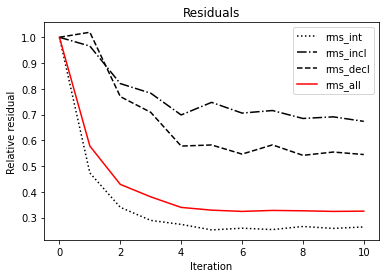

In [19]:
# We start by plotting the rms of various types per iteration
# start a figure
fig, ax = plt.subplots()
ax.set_title('Residuals')
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative residual')
# make a call to the plotting library, input ax and our FieldInversion instance
ax = plot_tools.plot_residuals(ax, test_inv)
ax.legend(loc='upper right')
plt.show()

#### powerspectra (to be updated)
The `plot_tools.plot_powerspectrum` allows the plotting of the powerspectrum of the gaussian coefficients. The default option is to plot the energy 'stored' in each degree together with its temporal variance.

It is also possible to plot the individual gaussian coefficients with its temporal variance over certain time intervals.

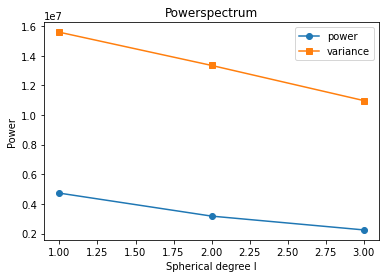

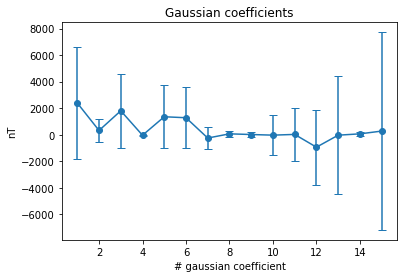

In [20]:
# start figure
fig, ax = plt.subplots()
ax.set_title('Powerspectrum')
ax.set_xlabel('Spherical degree l')
ax.set_ylabel('Power')
# make a call to the plotting library
ax = plot_tools.plot_powerspectrum(ax, test_inv)
ax.legend(loc='upper right')
plt.show()

# now we plot the mean gaussian coefficients through a time interval with std
fig, ax = plt.subplots()
ax.set_title('Gaussian coefficients')
ax.set_xlabel('# gaussian coefficient')
ax.set_ylabel('nT')
ax = plot_tools.plot_powerspectrum(ax, test_inv, power=False, plot_time=np.arange(10))
plt.show()

#### gaussian coefficients
By using `plot_tools.plot_gaussian` we can plot the gaussian coefficients through time. It plots all gaussian coefficients of the same degree at once, but we could also decide to define yourself which coefficients to plot by setting `degree, order, and h_bool` (see `plot_tools.plot_gaussian?`). It defaults to using the coefficients calculated in the last iteration, but we could choose otherwise by setting plot_iter to something else than -1.

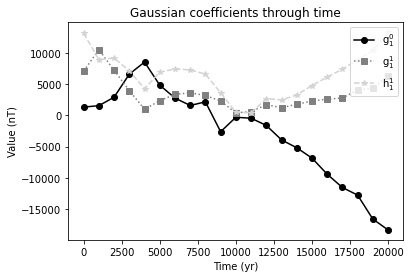

In [21]:
fig, ax = plt.subplots()
ax.set_title('Gaussian coefficients through time')
ax.set_xlabel('Time (yr)')
ax.set_ylabel('Value (nT)')
# we only want to plot gaussian coefficients of degree 1
ax = plot_tools.plot_gaussian(ax, test_inv, plot_degree=1)
ax.legend(loc='upper right')
plt.show()

#### forward calculations
After calculation of the gaussian coefficients, we plot their effect on a worldmap and on one location. For the worldmap, we define 3 axes and choose a projection. We choose a time we want to plot and set contourlevels with optional keyword arguments.

/home/out/anaconda3/envs/fieldmodel/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


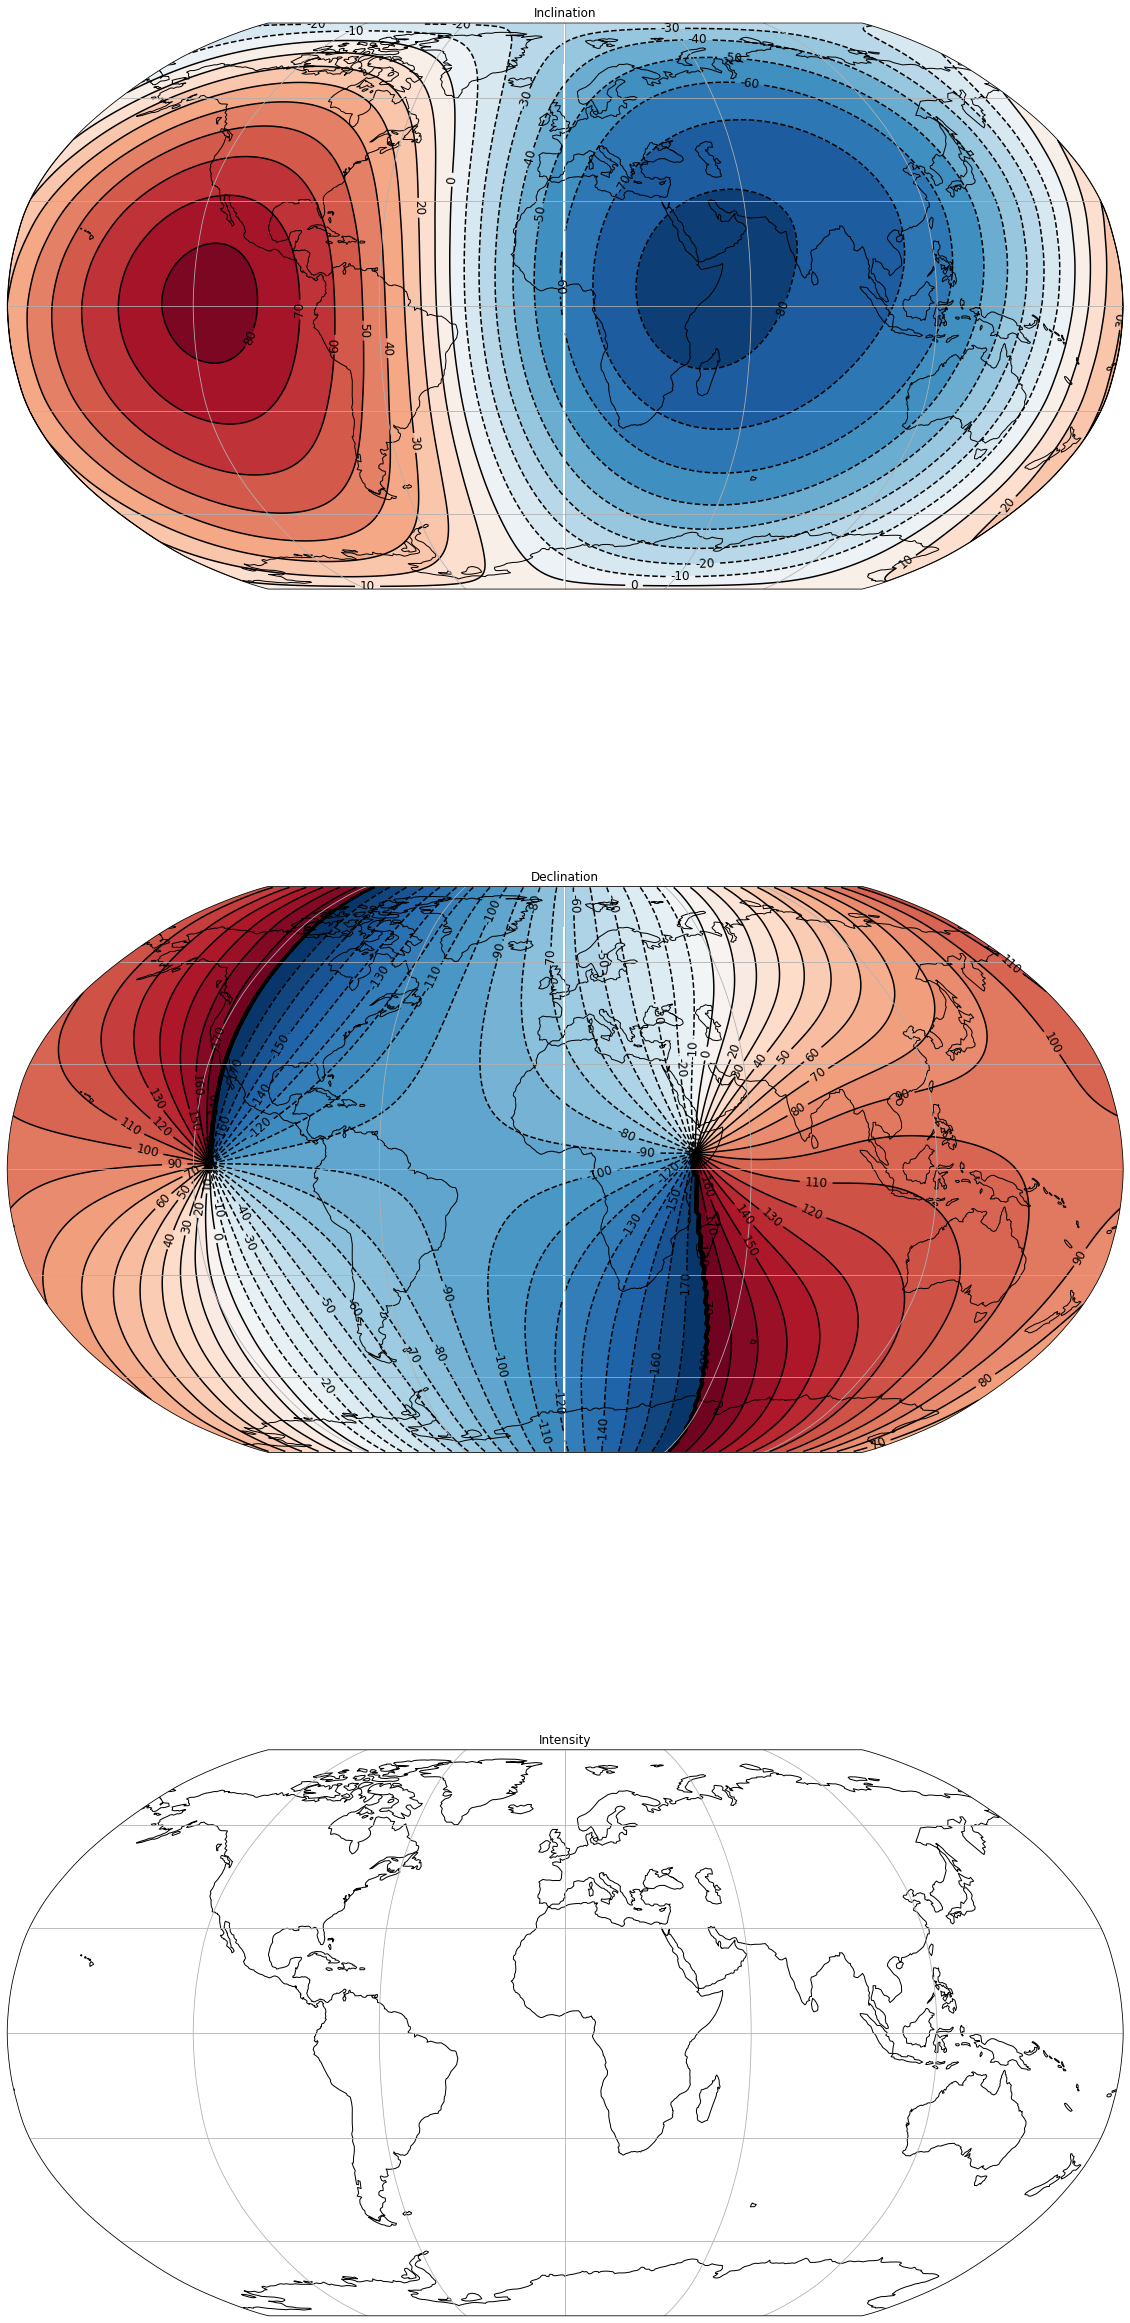

In [22]:
# set three axes and apply a Robinson world projection
fig, axes = plt.subplots(nrows=3, figsize=(20, 45), subplot_kw={'projection': ccrs.Robinson()})
# set some keyword arguments for the plotting, for all options see plot_tools.plot_world?
plot_kw = {'level_int': np.arange(1000, 3000, 100), 'levelf_int': np.arange(1000, 3000, 100)}
# call the function; input axes and inversion class, but also wished projection, plot time, and optional plotting keywords
axes = plot_tools.plot_world(axes, test_inv, projection=ccrs.PlateCarree(), plot_time=0, plot_kw=plot_kw)
plt.show()

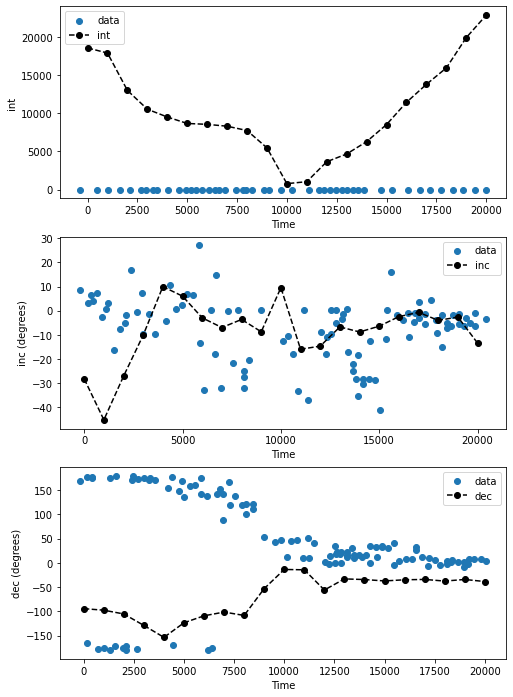

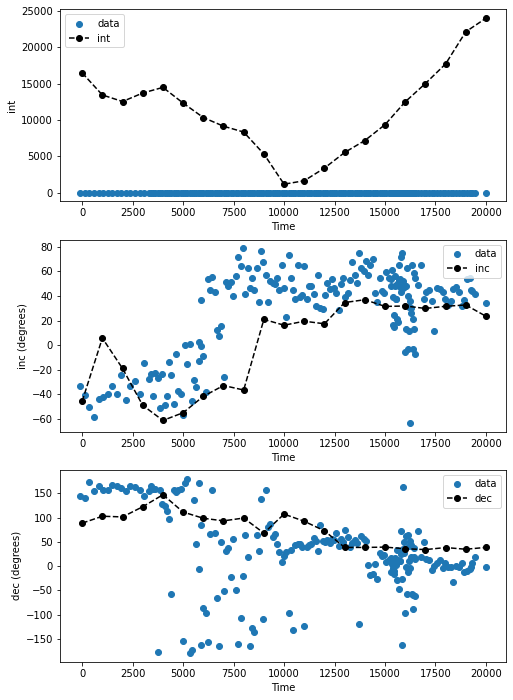

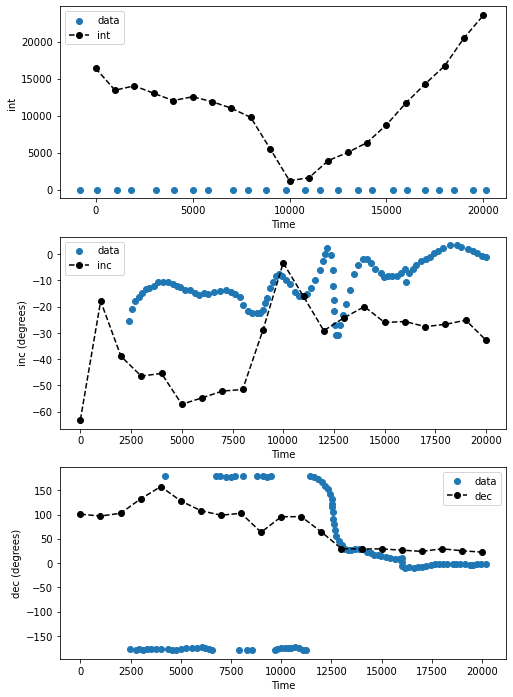

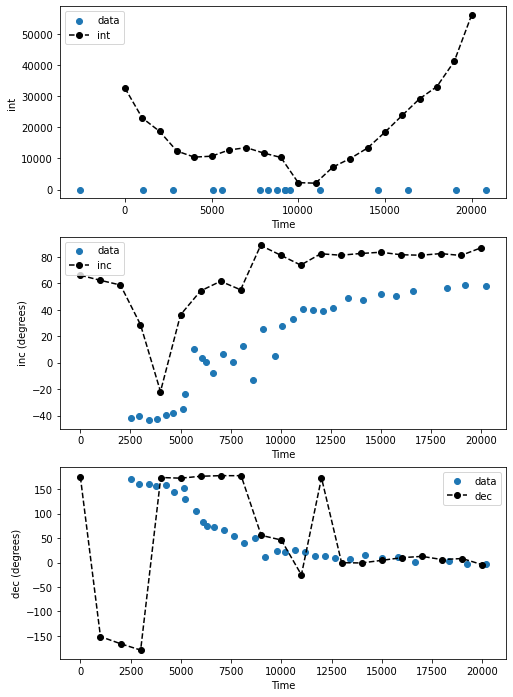

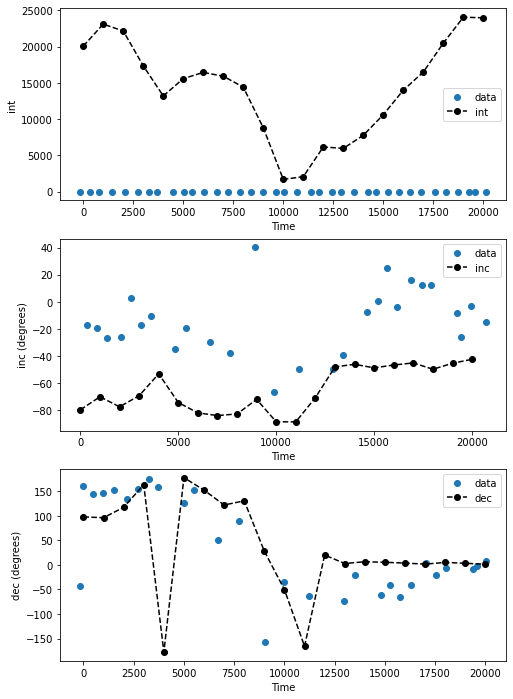

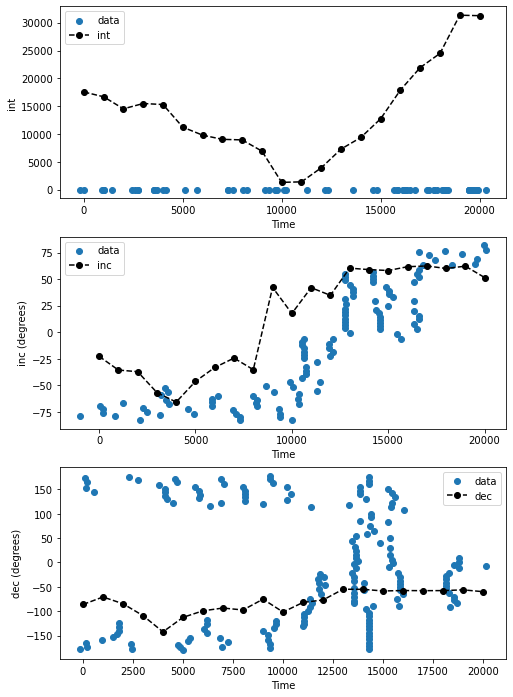

In [23]:
for sheet in [valet_1989, haneda_2020, oda_2000, valet_1988, valet_2014, channell_2000]:
    print(sheet)
    fig, axes = plt.subplots(len(sheet.types), 1, figsize=(8, 4*len(sheet.types)))
    axes = plot_tools.compare_loc(axes, test_inv, sheet)
    plt.show()

## 3. Sweeping through models to find optimal damping parameters
Normally we do not have the optimal damping parameters yet, which is why we will have to search for them **now**. 
We will start a new class and add all our data, then we will sweep through a range of spatial and temporal damping parameters. By plotting model size versus residuals, we will find the best fitting parameters.

In [16]:
# set class and add data
sweep_inv = FieldInversion(time_array = np.linspace(3000, 17000, 15))

sweep_inv.add_data(valet_1989)
sweep_inv.add_data(haneda_2020)
sweep_inv.add_data(oda_2000)
sweep_inv.add_data(valet_1988)
sweep_inv.add_data(valet_2014)
sweep_inv.add_data(channell_2000)

#### *sweep_damping*
This method enables us to sweep through the parameters, it needs:
- spatial_range: the range of spatial damping parameters to be tested
- temporal_range: the range of temporal damping parameters to be tested
- x0: starting model of gaussian coefficients

Result can be saved to a folder with the optional dictionary save_kwargs

In [17]:
spatial_range = np.logspace(-12, -8, 5)
temporal_range = np.logspace(0, 10, 5)
x0 = np.zeros(15)
x0[0] = -30000

sweep_inv.sweep_damping(x0, spatial_range, temporal_range, save_kwargs={'basedir': path / 'output', 'save_residual': True})

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


After performing the calculations, we can plot the results of the damping parameters with `plot_tools.plot_sweep`. For the first plot we hold temporal damping; in the second plot we hold spatial damping. The best model would be the model that produces a low residual and a small model size (=norm of the gaussian coefficients).

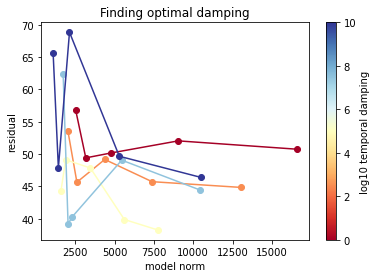

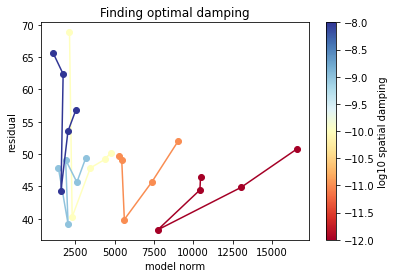

In [18]:
# Now we plot residual vs norm of the model
fig, ax = plt.subplots()
ax.set_title('Finding optimal damping')
ax.set_xlabel('model norm')
ax.set_ylabel('residual')
# call function to plot lines
ax = plot_tools.plot_sweep(ax, spatial_range, temporal_range, plot_spatial=True,
                           basedir=path / 'output')
# define colors and a colorbar
norm = mpl.colors.Normalize(vmin=np.log10(temporal_range[0]), vmax=np.log10(temporal_range[-1]))
sm = plt.cm.ScalarMappable(cmap='RdYlBu', norm=norm)
plt.colorbar(sm, label='log10 temporal damping')
plt.show()

# now we hold the spatial damping parameter
fig, ax = plt.subplots()
ax.set_title('Finding optimal damping')
ax.set_xlabel('model norm')
ax.set_ylabel('residual')
ax = plot_tools.plot_sweep(ax, spatial_range, temporal_range, plot_spatial=False,
                           basedir=path / 'output')
norm = mpl.colors.Normalize(vmin=np.log10(spatial_range[0]), vmax=np.log10(spatial_range[-1]))
sm = plt.cm.ScalarMappable(cmap='RdYlBu', norm=norm)
plt.colorbar(sm, label='log10 spatial damping')
plt.show()

#### conclusion
A spatial damping factor of 1e-9 seems to be best; it results in both a low residual and small gaussian coefficients. For the temporal damping factor, it is slightly harder to judge. For now we will assume a temporal damping factor of 1e6. These damping parameters could then be used in the main model (see section 2).

## 4. Run an inversion at one time
The code does also work for one timestep. However, to execute the inversion we have to call `run_inversion_notime` instead of `run_inversion`.

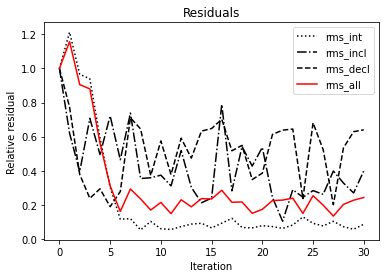

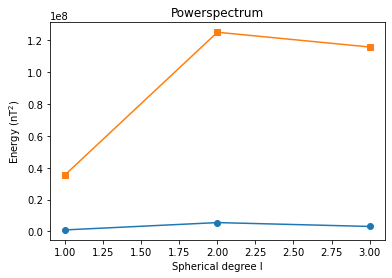

In [19]:
one_inv = FieldInversion(time_array = [6000])
one_inv.add_data(valet_1989)
one_inv.add_data(haneda_2020)
one_inv.add_data(oda_2000)
one_inv.add_data(valet_1988)
one_inv.add_data(valet_2014)
one_inv.add_data(channell_2000)
one_inv.prepare_inversion(spatial_df = 1e-10, temporal_df = 0)
x0 = np.zeros(15)
x0[0] = -30000
one_inv.run_inversion_notime(x0, max_iter=30, int_mult=1e4)
one_inv.save_spherical_coefficients(path / 'output', save_residual=True)

fig, ax = plt.subplots()
ax.set_title('Residuals')
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative residual')
ax = plot_tools.plot_residuals(ax, one_inv)
ax.legend(loc='upper right')
plt.show()

fig, ax = plt.subplots()
ax.set_title('Powerspectrum')
ax.set_xlabel('Spherical degree l')
ax.set_ylabel('Energy (nT$^2$)')
ax = plot_tools.plot_powerspectrum(ax, one_inv)
plt.show()